In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [25]:
from io import StringIO

aa = '''iupac\tthree_letter	name
A	Ala	Alanine
C	Cys	Cysteine
D	Asp	Aspartic Acid
E	Glu	Glutamic Acid
F	Phe	Phenylalanine
G	Gly	Glycine
H	His	Histidine
I	Ile	Isoleucine
K	Lys	Lysine
L	Leu	Leucine
M	Met	Methionine
N	Asn	Asparagine
P	Pro	Proline
Q	Gln	Glutamine
R	Arg	Arginine
S	Ser	Serine
T	Thr	Threonine
V	Val	Valine
W	Trp	Tryptophan
Y	Tyr	Tyrosine'''
aa_df = pd.read_csv(StringIO(aa), sep='\t')
aa_df
aminoacids = aa_df['iupac']


In [67]:
mutscores_df = pd.read_csv('results/mutscan_MAX.tsv', sep='\t')
mutscores_df = mutscores_df.assign(
    wt_residue=lambda df:df['MUTATION'].apply(lambda x: x[0]),
    mut_idx=lambda df:df['MUTATION'].apply(lambda x: int(x[1:-1])),
)
mutscores_df = mutscores_df[(mutscores_df['residue'] != mutscores_df['wt_residue']) & (mutscores_df['residue'].isin(aminoacids))]
mutscores_df.sort_values('score')

,Unnamed: 0,Unnamed: 0.1,GENEINFO,AA_CHANGE,GROUP,MUTATION,GENE,model,residue,sequence_idx,score,wt_residue,mut_idx
261043,2323,18496,MAX:4149,Gln112His,VUS,Q112H,MAX,esm1v_t33_650M_UR90S_1,P,84,-25.143143,Q,112
493363,2323,18541,MAX:4149|LOC100506321:100506321,Ser45Gly,VUS,S45G,MAX,esm1v_t33_650M_UR90S_1,P,84,-25.118130,S,45
393043,2323,18521,MAX:4149,Gln82Glu,VUS,Q82E,MAX,esm1v_t33_650M_UR90S_1,P,84,-25.107416,Q,82
160723,2323,18481,MAX:4149,Lys127Arg,VUS,K127R,MAX,esm1v_t33_650M_UR90S_1,P,84,-25.085285,K,127
403603,2323,18526,MAX:4149,Tyr70Cys,VUS,Y70C,MAX,esm1v_t33_650M_UR90S_1,P,84,-25.078152,Y,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498124,1804,18541,MAX:4149|LOC100506321:100506321,Ser45Gly,VUS,S45G,MAX,esm1v_t33_650M_UR90S_1,T,45,6.570588,S,45
524657,1937,18546,MAX:4149|LOC100506321:100506321,Asp23Asn,VUS,D23N,MAX,esm1v_t33_650M_UR90S_1,I,18,6.604476,D,23
524182,1462,18546,MAX:4149|LOC100506321:100506321,Asp23Asn,VUS,D23N,MAX,esm1v_t33_650M_UR90S_1,E,23,7.075475,D,23
492844,1804,18541,MAX:4149|LOC100506321:100506321,Ser45Gly,VUS,S45G,MAX,esm1v_t33_650M_UR90S_1,T,45,7.491083,S,45


In [68]:
mutscores_df['MUTATION'].unique(), mutscores_df['GROUP'].unique()

(array(['A159T', 'E143D', 'D139N', 'G136R', 'I131V', 'K127R', 'N120S',
        'P116A', 'Q112H', 'Q110E', 'E103G', 'L94V', 'R90Q', 'Q82E', 'Y70C',
        'A58V', 'R47Q', 'S45G', 'D23N', 'P16L', 'V9L'], dtype=object),
 array(['VUS', 'B/LB'], dtype=object))

Text(0.5, 1.0, 'MAX')

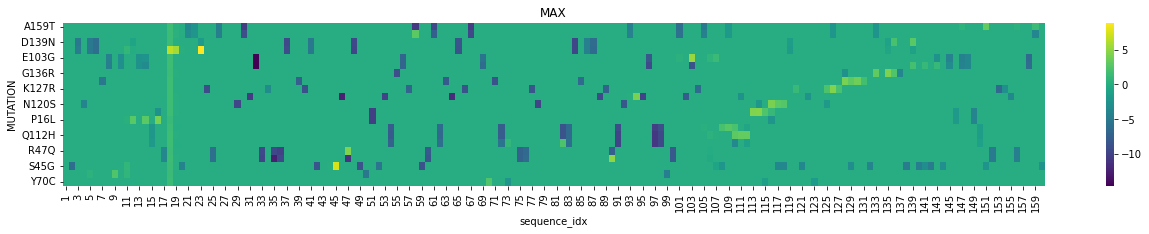

In [69]:
plt.figure(figsize=(22,3))
sns.heatmap(
    data=(mutscores_df
          .sort_values('mut_idx')
          .groupby(['MUTATION', 'sequence_idx'])['score'].max()
          .reset_index()
          .pivot(index='MUTATION', columns='sequence_idx', values='score')
         ),
    cmap='viridis'
)
plt.title(mutscores_df['GENE'].values[0])

/home/tsuname/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


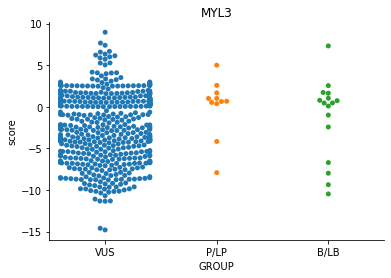

In [63]:
sns.swarmplot(
    data=(mutscores_df
          .groupby(['MUTATION', 'GROUP', 'sequence_idx'])['score'].max()
          .reset_index()
          .query('score > 0.01 | score < -0.01')
         ),
    x='GROUP',
    y='score'
)
plt.title(mutscores_df['GENE'].values[0])
sns.despine()